# Lista de exercísios #3

**Dataset:** `/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Data_2016_RM_xgb.csv` 

**Context:** Vamos buscar nos dados reais do LHCb o decaimento $ B \to K^{*}\mu^+\mu^- $  
**Libraries:** NumPy, pandas, scikit-learn, matplotlib, zfit

In [3]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Vamos inicialmente checar o que são os xgb_score aplicados nos dados reais

['B0_M', 'B0_P', 'B0_PT', 'B0_DIRA_OWNPV', 'B0_ENDVERTEX_CHI2', 'B0_TAU', 'K_PIDK', 'Pi_PIDK', 'mu_plus_PIDmu', 'mu_minus_PIDmu', 'B0_FDCHI2_OWNPV', 'B0_IPCHI2_OWNPV', 'K_IPCHI2_OWNPV', 'Pi_IPCHI2_OWNPV', 'mu_plus_IPCHI2_OWNPV', 'mu_minus_IPCHI2_OWNPV', 'q2', 'xgb_score']


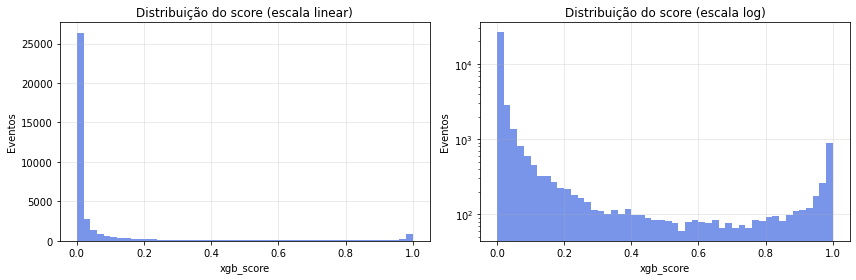

In [5]:
# Load do dataset que salvamos o treinamento
df = pd.read_csv('/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Data_2016_RM_xgb.csv')

# Vamos checar se a amostra esta ok
print(df.columns.tolist())

# Visualizar distribuição dos weights
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(df["xgb_score"], bins=50, color='royalblue', alpha=0.7)
plt.xlabel("xgb_score")
plt.ylabel("Eventos")
plt.title("Distribuição do score (escala linear)")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df["xgb_score"], bins=50, color='royalblue', alpha=0.7)
plt.yscale("log")
plt.xlabel("xgb_score")
plt.ylabel("Eventos")
plt.title("Distribuição do score (escala log)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Visualizar o impact de um corte "random" no xgb_score para a massa

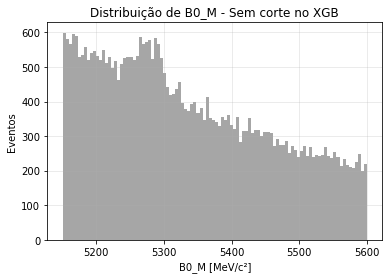

In [6]:
# Sem cortes
plt.figure(figsize=(6,4))
plt.hist(df["B0_M"], bins=100, color='gray', alpha=0.7)
plt.xlabel("B0_M [MeV/c²]")
plt.ylabel("Eventos")
plt.title("Distribuição de B0_M - Sem corte no XGB")
plt.grid(alpha=0.3)
plt.show()

Aplicando corte: xgb_score > 0.0


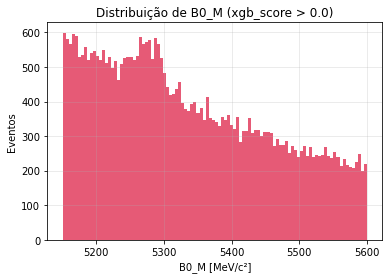

In [51]:
# Escolher um corte
xgb_cut = 0.0
print(f"Aplicando corte: xgb_score > {xgb_cut}")
df_cut = df[df["xgb_score"] > xgb_cut]

plt.figure(figsize=(6,4))
plt.hist(df_cut["B0_M"], bins=100, color='crimson', alpha=0.7)
plt.xlabel("B0_M [MeV/c²]")
plt.ylabel("Eventos")
plt.title(f"Distribuição de B0_M (xgb_score > {xgb_cut})")
plt.grid(alpha=0.3)
plt.show()

# Definindo a FoM

In [47]:
def significance_fom(S, B):
    """Calcula a figura de mérito S/sqrt(S+B)."""
    if (S + B) == 0:
        return 0
    return S / np.sqrt(S + B)

# Simples fit desta distribuicao 

Eventos após corte e janela: 38571
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_87, Composed_autoparam_88]] data=[<zfit.Data: Data obs=('B0_M',) shape=(38571, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═══════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm  │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═══════╪══════════════════════════════╡
│  True   │    True     │      False       │ 5e-05 │        233652.70 |  1953.311 │
╘═════════╧═════════════╧══════════════════╧═══════╧══════════════════════════════╛

Parameters
name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
nsig               1435.03  +/- 1.3e+02       False
nbkg               37135.5  +/- 2.3e+02       False
mu                 5278.27  +/-     1.7       False
sigma              19.5127  

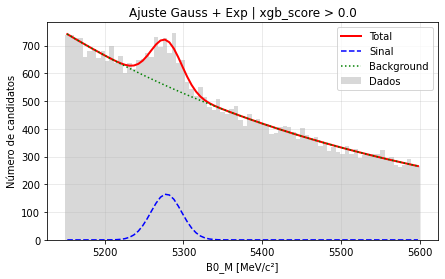

Signal yield:  1435.0297751248227


In [63]:
import zfit
from zfit import z
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimizers.minimizer_minuit import Minuit

# Selecionar o range de massa
mass_min, mass_max = 5150.0, 5600.0
mass = df_cut.query(f"{mass_min} <= B0_M <= {mass_max}")["B0_M"].to_numpy()

print(f"Eventos após corte e janela: {len(mass)}")

# zfit!
obs = zfit.Space('B0_M', limits=(mass_min, mass_max))

mu     = zfit.Parameter("mu",     5280.0, 5200.0, 5360.)
sigma  = zfit.Parameter("sigma",    30.0,    5.0,   60.0)
tau    = zfit.Parameter("tau",     -0.003,  -1.0,  0.0)  

# yields
N_tot = len(mass)
nsig = zfit.Parameter("nsig", 0.5 * N_tot, 0., 1.5 * N_tot)
nbkg = zfit.Parameter("nbkg", 0.5 * N_tot, 0., 1.5 * N_tot)

# PDFs
signal_pdf = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs, extended=nsig)
bkg_pdf    = zfit.pdf.Exponential(lambda_=tau, obs=obs, extended=nbkg)

# PDF total
model = zfit.pdf.SumPDF([signal_pdf, bkg_pdf])

data_z = zfit.Data.from_numpy(obs=obs, array=mass)
loss   = ExtendedUnbinnedNLL(model=model, data=data_z)

minim  = Minuit()
result = minim.minimize(loss)
result.hesse()  # calcula incertezas

print(result)

# Plotting
bins = 80
vals, edges = np.histogram(mass, bins=bins, range=(mass_min, mass_max))
centers = 0.5 * (edges[:-1] + edges[1:])
width = edges[1] - edges[0]

pdf_sig = zfit.run(signal_pdf.pdf(centers))
pdf_bkg = zfit.run(bkg_pdf.pdf(centers))

y_sig = pdf_sig * nsig.value() * width
y_bkg = pdf_bkg * nbkg.value() * width


plt.figure(figsize=(7,4))
plt.bar(centers, vals, width=width, alpha=0.3, color='gray', label='Dados')
plt.plot(centers, y_sig + y_bkg, 'r-', lw=2, label='Total')
plt.plot(centers, y_sig, 'b--', label='Sinal')
plt.plot(centers, y_bkg, 'g:', label='Background')
plt.xlabel("B0_M [MeV/c²]")
plt.ylabel("Número de candidatos")
plt.title(f"Ajuste Gauss + Exp | xgb_score > {xgb_cut}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

NSig_Ref = zfit.run(nsig.value())
print("Signal yield: ", zfit.run(nsig.value()))

# Calculando a "yield" para cada corte

In [61]:
df_mc = pd.read_csv('/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_MC_xgb.csv')

df_sig = df_mc[df_mc["label"] == 1].copy()
print(f"Eventos de sinal no MC: {len(df_sig)}")

thresholds = np.arange(0.0, 1.05, 0.05)

# Total
N0 = len(df_sig)

# Calcular eficiência relativa do sinal
eff_rel = [(df_sig["xgb_score"] > t).sum() / N0 for t in thresholds]

# Colocar num data frame ou dicionario
eff_table = pd.DataFrame({"cut": thresholds, "eff_rel": eff_rel})
display(eff_table.head())

print(f"Yield de referência S = {NSig_Ref:.1f}")

# Adicionar coluna com yield relativo estimado
eff_table["S_est"] = NSig_Ref * eff_table["eff_rel"]
display(eff_table.head(10))

Eventos de sinal no MC: 10001


,cut,eff_rel
0,0.00,1.000000
1,0.05,0.997200
2,0.10,0.994401
3,0.15,0.990701
4,0.20,0.987801


Yield de referência S = 1435.0


,cut,eff_rel,S_est
0,0.00,1.000000,1435.029775
1,0.05,0.997200,1431.012094
2,0.10,0.994401,1426.994412
3,0.15,0.990701,1421.685333
4,0.20,0.987801,1417.524162
5,0.25,0.984502,1412.789038
6,0.30,0.980302,1406.762515
7,0.35,0.976902,1401.883902
8,0.40,0.972603,1395.713891
9,0.45,0.968203,1389.400391


# Estimando o background

Eventos no sideband: 11916
FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.basic.Exponential'>  params=[tau_bkg, tau_bkg]] data=[<zfit.Data: Data obs=('B0_M',) shape=(11916, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 1.2e-08 │         63029.37 |  9990.656 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name       value  (rounded)        hesse    at limit
-------  ------------------  -----------  ----------
tau_bkg         -0.00230966  +/- 0.00016       False


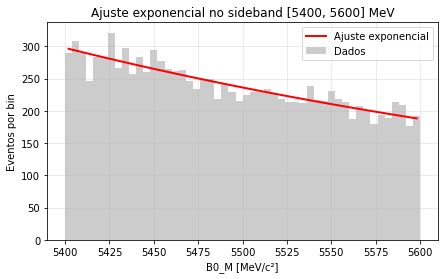

In [65]:
# Fit simples para referencia
from zfit.loss import UnbinnedNLL

mass_min_bkg, mass_max_bkg = 5400., 5600.
mass_bkg = df_cut.query(f"{mass_min_bkg} <= B0_M <= {mass_max_bkg}")["B0_M"].to_numpy()
print(f"Eventos no sideband: {len(mass_bkg)}")

obs_bkg = zfit.Space("B0_M", limits=(mass_min_bkg, mass_max_bkg))
tau_bkg = zfit.Parameter("tau_bkg", -0.003, -0.2, -1e-6)
bkg_pdf = zfit.pdf.Exponential(lambda_=tau_bkg, obs=obs_bkg)

data_bkg = zfit.Data.from_numpy(obs=obs_bkg, array=mass_bkg)
loss_bkg = UnbinnedNLL(model=bkg_pdf, data=data_bkg)
minim = Minuit()
result = minim.minimize(loss_bkg)
result.hesse()

print(result)

bins = 50
vals, edges = np.histogram(mass_bkg, bins=bins, range=(mass_min_bkg, mass_max_bkg))
centers = 0.5*(edges[:-1] + edges[1:])
width = edges[1] - edges[0]

pdf_vals = zfit.run(bkg_pdf.pdf(centers))
pdf_scaled = pdf_vals * len(mass_bkg) * width 

plt.figure(figsize=(7,4))
plt.bar(centers, vals, width=width, color='gray', alpha=0.4, label='Dados')
plt.plot(centers, pdf_scaled, 'r-', lw=2, label='Ajuste exponencial')
plt.xlabel("B0_M [MeV/c²]")
plt.ylabel("Eventos por bin")
plt.title("Ajuste exponencial no sideband [5400, 5600] MeV")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [68]:
# limites da janela de interesse
mass_min_sig, mass_max_sig = 5239., 5319.

N_fit_bkg_simple = len(mass_bkg)


tau_val_bkg_simple = float(tau_bkg.value())

def integral_exp(lmbda, a, b):
    if abs(lmbda) < 1e-12:
        return b - a
    return (np.exp(lmbda * b) - np.exp(lmbda * a)) / lmbda

# fração da área da exponencial entre as regiões
num = integral_exp(tau_val_bkg_simple, mass_min_sig, mass_max_sig)
den = integral_exp(tau_val_bkg_simple, mass_min_bkg, mass_max_bkg)
frac = num / den

# estimativa de background na janela de sinal
B_est = N_fit_bkg_simple * frac
print(f"Background estimado em [{mass_min_sig:.0f}, {mass_max_sig:.0f}] MeV:")
print(f"N_bkg_simple = {B_est:.1f} eventos")


Background estimado em [5239, 5319] MeV:
N_bkg_simple = 7881.9 eventos


# Vamos fazer de forma interativa agora para os varios cortes

In [73]:
B_est_list = []

for t in eff_table["cut"]:
    df_cut = df[df["xgb_score"] > t]
    mass_bkg = df_cut.query(f"{mass_min_bkg} <= B0_M <= {mass_max_bkg}")["B0_M"].to_numpy()
    N_fit_bkg_simple = len(mass_bkg)

    obs_bkg = zfit.Space("B0_M", limits=(mass_min_bkg, mass_max_bkg))
    tau_bkg = zfit.Parameter("tau_bkg", -0.003, -0.2, -1e-6)
    bkg_pdf = zfit.pdf.Exponential(lambda_=tau_bkg, obs=obs_bkg)
    data_bkg = zfit.Data.from_numpy(obs=obs_bkg, array=mass_bkg)
    loss_bkg = UnbinnedNLL(model=bkg_pdf, data=data_bkg)
    minim = Minuit()
    result = minim.minimize(loss_bkg)

    tau_val = float(tau_bkg.value())

    # calcular fração
    num = integral_exp(tau_val, mass_min_sig, mass_max_sig)
    den = integral_exp(tau_val, mass_min_bkg, mass_max_bkg)
    frac = num / den

    # estimar número esperado 
    B_est = N_fit_bkg_simple * frac
    B_est_list.append(B_est)

eff_table["B_est"] = B_est_list
display(eff_table.head(10))

,cut,eff_rel,S_est,B_est
0,0.00,1.000000,1435.029775,7881.932042
1,0.05,0.997200,1431.012094,1583.481239
2,0.10,0.994401,1426.994412,1080.034743
3,0.15,0.990701,1421.685333,965.826014
4,0.20,0.987801,1417.524162,788.932914
5,0.25,0.984502,1412.789038,678.724651
6,0.30,0.980302,1406.762515,602.736873
7,0.35,0.976902,1401.883902,559.614412
8,0.40,0.972603,1395.713891,465.151200
9,0.45,0.968203,1389.400391,412.188227


# Finalmente: vamos calcular o FoM

,cut,eff_rel,S_est,B_est,FoM
0,0.00,1.000000,1435.029775,7881.932042,14.867014
1,0.05,0.997200,1431.012094,1583.481239,26.063704
2,0.10,0.994401,1426.994412,1080.034743,28.499850
3,0.15,0.990701,1421.685333,965.826014,29.095831
4,0.20,0.987801,1417.524162,788.932914,30.177463
5,0.25,0.984502,1412.789038,678.724651,30.892066
6,0.30,0.980302,1406.762515,602.736873,31.381728
7,0.35,0.976902,1401.883902,559.614412,31.653233
8,0.40,0.972603,1395.713891,465.151200,32.354818
9,0.45,0.968203,1389.400391,412.188227,32.734039


Melhor corte encontrado:
  xgb_score > 0.50
  FoM = 32.905


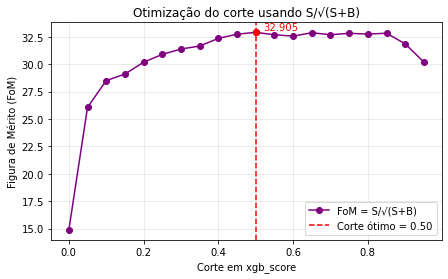

In [74]:
fom_values = []  

for i in range(len(eff_table)):
    S = eff_table.loc[i, "S_est"]
    B = eff_table.loc[i, "B_est"]
    fom = significance_fom(S, B)
    fom_values.append(fom)


eff_table["FoM"] = fom_values
display(eff_table.head(10))

# Maximo
imax = eff_table["FoM"].idxmax()
best_cut = eff_table.loc[imax, "cut"]
best_fom = eff_table.loc[imax, "FoM"]

print(f"Melhor corte encontrado:")
print(f"  xgb_score > {best_cut:.2f}")
print(f"  FoM = {best_fom:.3f}")

plt.figure(figsize=(7,4))
plt.plot(eff_table["cut"], eff_table["FoM"], marker='o', color='purple', label="FoM = S/√(S+B)")
plt.axvline(best_cut, color='red', ls='--', lw=1.5, label=f"Corte ótimo = {best_cut:.2f}")
plt.scatter(best_cut, best_fom, color='red', zorder=5)
plt.text(best_cut + 0.02, best_fom, f"{best_fom:.3f}", color='red', fontsize=10, va='bottom')

plt.xlabel("Corte em xgb_score")
plt.ylabel("Figura de Mérito (FoM)")
plt.title("Otimização do corte usando S/√(S+B)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# Finalmente, nosso plot final

Eventos após corte e janela: 3177
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_108, Composed_autoparam_109]] data=[<zfit.Data: Data obs=('B0_M',) shape=(3177, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═══════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm  │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═══════╪══════════════════════════════╡
│  True   │    True     │      False       │ 2e-05 │         18225.50 |  9909.615 │
╘═════════╧═════════════╧══════════════════╧═══════╧══════════════════════════════╛

Parameters
name         value  (rounded)        hesse    at limit
---------  ------------------  -----------  ----------
nsig_cut              1084.49  +/-      45       False
nbkg_cut              2092.66  +/-      55       False
mu_cut                5278.98  +/-    0.78       False
sigma_cut    

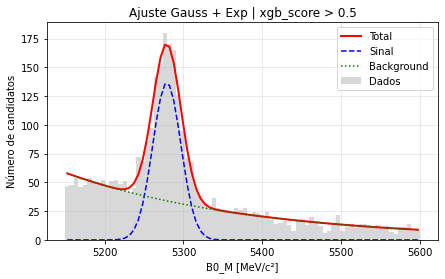

In [91]:
xgb_cut = 0.5  
df_cut = df[df["xgb_score"] > xgb_cut].copy()
mass_min_cut, mass_max_cut = 5150.0, 5600.0
mass_cut = df_cut.query(f"{mass_min_cut} <= B0_M <= {mass_max_cut}")["B0_M"].to_numpy()
print(f"Eventos após corte e janela: {len(mass_cut)}")


obs_cut = zfit.Space('B0_M', limits=(mass_min_cut, mass_max_cut))

mu_cut     = zfit.Parameter("mu_cut",     5280.0, 5200.0, 5360.0)
sigma_cut  = zfit.Parameter("sigma_cut",    30.0,    5.0,   60.0)
tau_cut    = zfit.Parameter("tau_cut",     -0.003,  -1.0,   0.0)  

N_tot_cut = len(mass_cut)
nsig_cut  = zfit.Parameter("nsig_cut", 0.5 * N_tot_cut, 0., 1.5 * N_tot_cut)
nbkg_cut  = zfit.Parameter("nbkg_cut", 0.5 * N_tot_cut, 0., 1.5 * N_tot_cut)

signal_pdf_cut = zfit.pdf.Gauss(mu=mu_cut, sigma=sigma_cut, obs=obs_cut, extended=nsig_cut)
bkg_pdf_cut    = zfit.pdf.Exponential(lambda_=tau_cut, obs=obs_cut, extended=nbkg_cut)

model_cut = zfit.pdf.SumPDF([signal_pdf_cut, bkg_pdf_cut])

data_cut = zfit.Data.from_numpy(obs=obs_cut, array=mass_cut)
loss_cut = ExtendedUnbinnedNLL(model=model_cut, data=data_cut)

minim_cut = Minuit()
result_cut = minim_cut.minimize(loss_cut)
result_cut.hesse()

print(result_cut)

bins = 80
vals, edges = np.histogram(mass_cut, bins=bins, range=(mass_min_cut, mass_max_cut))
centers = 0.5 * (edges[:-1] + edges[1:])
width = edges[1] - edges[0]

pdf_sig_cut = zfit.run(signal_pdf_cut.pdf(centers))
pdf_bkg_cut = zfit.run(bkg_pdf_cut.pdf(centers))

y_sig_cut = pdf_sig_cut * nsig_cut.value() * width
y_bkg_cut = pdf_bkg_cut * nbkg_cut.value() * width

plt.figure(figsize=(7,4))
plt.bar(centers, vals, width=width, alpha=0.3, color='gray', label='Dados')
plt.plot(centers, y_sig_cut + y_bkg_cut, 'r-', lw=2, label='Total')
plt.plot(centers, y_sig_cut, 'b--', label='Sinal')
plt.plot(centers, y_bkg_cut, 'g:', label='Background')
plt.xlabel("B0_M [MeV/c²]")
plt.ylabel("Número de candidatos")
plt.title(f"Ajuste Gauss + Exp | xgb_score > {xgb_cut}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Significancia do sinal!

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_90, Composed_autoparam_91]] data=[<zfit.Data: Data obs=('B0_M',) shape=(3177, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  False  │    True     │      False       │ 7.3e-13 │         18832.45 |  10004.29 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
nbkg_cut                 3177       False
mu_cut                5278.98       False
sigma_cut             17.8123       False
tau_cut           -0.00493471       False


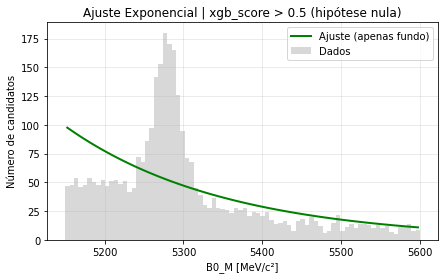

In [79]:
# Null hypothesis
nsig_cut.set_value(0.0)
nsig_cut.floating = False  

loss_null = ExtendedUnbinnedNLL(model=model_cut, data=data_cut)
minim_null = Minuit()
result_null = minim_null.minimize(loss_null)
result_null.hesse()
print(result_null)

bins = 80
vals, edges = np.histogram(mass_cut, bins=bins, range=(mass_min_cut, mass_max_cut))
centers = 0.5 * (edges[:-1] + edges[1:])
width = edges[1] - edges[0]

pdf_bkg_null = zfit.run(bkg_pdf_cut.pdf(centers))
y_bkg_null = pdf_bkg_null * nbkg_cut.value() * width

plt.figure(figsize=(7,4))
plt.bar(centers, vals, width=width, alpha=0.3, color='gray', label='Dados')
plt.plot(centers, y_bkg_null, 'g-', lw=2, label='Ajuste (apenas fundo)')
plt.xlabel("B0_M [MeV/c²]")
plt.ylabel("Número de candidatos")
plt.title(f"Ajuste Exponencial | xgb_score > {xgb_cut} (hipótese nula)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

[cut 0.0] Eventos no range: 38571
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_105, Composed_autoparam_106]] data=[<zfit.Data: Data obs=('B0_M',) shape=(38571, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═══════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm  │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═══════╪══════════════════════════════╡
│  True   │    True     │      False       │ 5e-05 │        233652.70 |  1953.311 │
╘═════════╧═════════════╧══════════════════╧═══════╧══════════════════════════════╛

Parameters
name           value  (rounded)        hesse    at limit
-----------  ------------------  -----------  ----------
nsig_cut01              1435.03  +/- 1.3e+02       False
nbkg_cut01              37135.5  +/- 2.3e+02       False
mu_cut01                5278.27  +/-     1.7       False
si

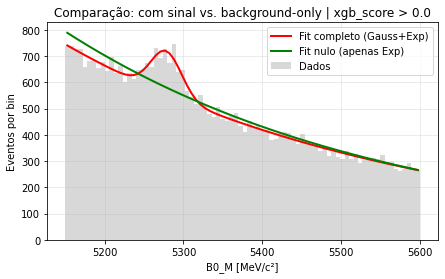

In [89]:
# Vamos fitar com e sem o sinal num exemplo mais "dificil"

xgb_cut01 = 0.0
df_cut01 = df[df["xgb_score"] > xgb_cut01].copy()

mass_min_cut01, mass_max_cut01 = 5150.0, 5600.0
mass_cut01 = df_cut01.query(f"{mass_min_cut01} <= B0_M <= {mass_max_cut01}")["B0_M"].to_numpy()
print(f"[cut {xgb_cut01}] Eventos no range: {len(mass_cut01)}")

obs_cut01 = zfit.Space('B0_M', limits=(mass_min_cut01, mass_max_cut01))

# Fit sig + bkg
mu_cut01     = zfit.Parameter("mu_cut01",     5280.0, 5200.0, 5360.0)
sigma_cut01  = zfit.Parameter("sigma_cut01",    30.0,    5.0,   60.0)
tau_cut01    = zfit.Parameter("tau_cut01",     -0.003,  -1.0,   0.0)

N_tot_cut01  = len(mass_cut01)
nsig_cut01   = zfit.Parameter("nsig_cut01", 0.5 * N_tot_cut01, 0., 1.5 * N_tot_cut01)
nbkg_cut01   = zfit.Parameter("nbkg_cut01", 0.5 * N_tot_cut01, 0., 1.5 * N_tot_cut01)

signal_pdf_cut01 = zfit.pdf.Gauss(mu=mu_cut01, sigma=sigma_cut01, obs=obs_cut01, extended=nsig_cut01)
bkg_pdf_cut01    = zfit.pdf.Exponential(lambda_=tau_cut01,       obs=obs_cut01, extended=nbkg_cut01)

model_full_cut01 = zfit.pdf.SumPDF([signal_pdf_cut01, bkg_pdf_cut01])

data_cut01 = zfit.Data.from_numpy(obs=obs_cut01, array=mass_cut01)
loss_full_cut01  = ExtendedUnbinnedNLL(model=model_full_cut01, data=data_cut01)

minim_full_cut01 = Minuit()
res_full_cut01   = minim_full_cut01.minimize(loss_full_cut01)
res_full_cut01.hesse()

print(res_full_cut01)


# Fit com a hypotese nula

tau_null01   = zfit.Parameter("tau_null01",   -0.003,  -1.0,   0.0)
nbkg_null01  = zfit.Parameter("nbkg_null01",  0.9 * N_tot_cut01, 0., 2.0 * N_tot_cut01)

bkg_pdf_null01   = zfit.pdf.Exponential(lambda_=tau_null01, obs=obs_cut01, extended=nbkg_null01)
model_null_cut01 = bkg_pdf_null01  # só fundo

loss_null_cut01  = ExtendedUnbinnedNLL(model=model_null_cut01, data=data_cut01)
minim_null_cut01 = Minuit()
res_null_cut01   = minim_null_cut01.minimize(loss_null_cut01)
res_null_cut01.hesse()
print(res_null_cut01)

bins = 80
vals, edges = np.histogram(mass_cut01, bins=bins, range=(mass_min_cut01, mass_max_cut01))
centers = 0.5 * (edges[:-1] + edges[1:])
width   = edges[1] - edges[0]

pdf_full_sig = zfit.run(signal_pdf_cut01.pdf(centers))
pdf_full_bkg = zfit.run(bkg_pdf_cut01.pdf(centers))
y_full_sig   = pdf_full_sig * nsig_cut01.value() * width
y_full_bkg   = pdf_full_bkg * nbkg_cut01.value() * width
y_full_tot   = y_full_sig + y_full_bkg

pdf_null_bkg = zfit.run(bkg_pdf_null01.pdf(centers))
y_null_tot   = pdf_null_bkg * nbkg_null01.value() * width

plt.figure(figsize=(7,4))
plt.bar(centers, vals, width=width, alpha=0.3, color='gray', label='Dados')
plt.plot(centers, y_full_tot,  'r-', lw=2, label='Fit completo (Gauss+Exp)')
plt.plot(centers, y_null_tot,  'g-', lw=2, label='Fit nulo (apenas Exp)')
plt.xlabel("B0_M [MeV/c²]")
plt.ylabel("Eventos por bin")
plt.title(f"Comparação: com sinal vs. background-only | xgb_score > {xgb_cut01}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [90]:
# Wilks theorem) 

# Log-likelihoods 
ll_full = -loss_full_cut01.value()   # ajuste Gauss + Exp
ll_null = -loss_null_cut01.value()   # ajuste apenas Exp

# Cálculo de Wilks
delta_logL = ll_full - ll_null
Z_wilks = np.sqrt(2 * delta_logL) if delta_logL > 0 else 0.0

print(f"LogL (full : Gauss+Exp) = {ll_full:.3f}")
print(f"LogL (null : Exp only)  = {ll_null:.3f}")
print(f"Δ(2lnL) = {2*delta_logL:.3f}")
print(f"Significância (Wilks) = {Z_wilks:.2f} σ")



LogL (full : Gauss+Exp) = -233652.702
LogL (null : Exp only)  = -233759.754
Δ(2lnL) = 214.104
Significância (Wilks) = 14.63 σ


# Vamos obter o sWeights do melhor fit que fizemos (usando sPlot)

In [95]:
from hepstats.splot import compute_sweights

weights = compute_sweights(model_cut, data_cut)

w_signal = weights[nsig_cut]
w_bkg    = weights[nbkg_cut]

print("Soma dos pesos de sinal:", np.sum(w_signal))
print("Soma dos pesos de fundo :", np.sum(w_bkg))

# Adicionar os pesos ao DataFrame de dados
df_cut = df_cut.copy()
df_cut["w_signal"] = w_signal
df_cut["w_bkg"] = w_bkg

Soma dos pesos de sinal: 1084.492943594547
Soma dos pesos de fundo : 2092.6651194334636


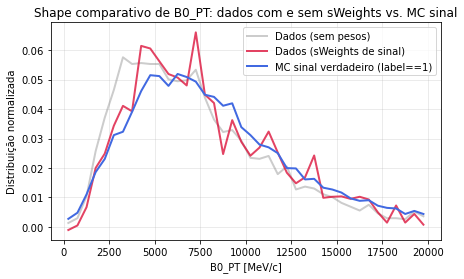

In [102]:
df_mc = pd.read_csv("/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_MC_xgb.csv")
df_mc_sig = df_mc[df_mc["label"] == 1].copy()

plt.figure(figsize=(7,4))

def normalized_hist(data, weights=None, bins=50, range=(0, 50_000), **kwargs):
    counts, bin_edges = np.histogram(data, bins=bins, range=range, weights=weights)
    centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    norm = np.sum(counts)
    if norm > 0:
        counts = counts / norm
    plt.plot(centers, counts, **kwargs)

normalized_hist(df_cut["B0_PT"], bins=40, range=(0, 20_000),
                color="gray", alpha=0.4, lw=2, label="Dados (sem pesos)")

normalized_hist(df_cut["B0_PT"], weights=df_cut["w_signal"],
                bins=40, range=(0, 20_000),
                color="crimson", alpha=0.8, lw=2, label="Dados (sWeights de sinal)")

normalized_hist(df_mc_sig["B0_PT"], bins=40, range=(0, 20_000),
                color="royalblue", lw=2, label="MC sinal verdadeiro (label==1)")

plt.xlabel("B0_PT [MeV/c]")
plt.ylabel("Distribuição normalizada")
plt.title("Shape comparativo de B0_PT: dados com e sem sWeights vs. MC sinal")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Vamos agora estudar como corrigir nossa simulacao usando um canal de controle

In [104]:
# Obter a amostra de referencia
df_jpsi_data = pd.read_csv("/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Data_2016_Jpsi.csv")

mass_min_jpsi, mass_max_jpsi = 5150.0, 5400.0
mass_jpsi = df_jpsi_data.query(f"{mass_min_jpsi} <= B0_M <= {mass_max_jpsi}")["B0_M"].to_numpy()
print(f"[J/psi dados] Eventos no range: {len(mass_jpsi)}")

obs_jpsi = zfit.Space("B0_M", limits=(mass_min_jpsi, mass_max_jpsi))

mu_jpsi    = zfit.Parameter("mu_jpsi",    5280.0, 5200.0, 5360.0)
sigma_jpsi = zfit.Parameter("sigma_jpsi",   25.0,    5.0,   60.0)
tau_jpsi   = zfit.Parameter("tau_jpsi",   -0.003,  -1.0,    0.0)

Ntot_jpsi  = len(mass_jpsi)
nsig_jpsi  = zfit.Parameter("nsig_jpsi",  0.7 * Ntot_jpsi, 0., 2.0 * Ntot_jpsi)  # J/ψ tem yield alto
nbkg_jpsi  = zfit.Parameter("nbkg_jpsi",  0.3 * Ntot_jpsi, 0., 2.0 * Ntot_jpsi)

signal_pdf_jpsi = zfit.pdf.Gauss(mu=mu_jpsi, sigma=sigma_jpsi, obs=obs_jpsi, extended=nsig_jpsi)
bkg_pdf_jpsi    = zfit.pdf.Exponential(lambda_=tau_jpsi,      obs=obs_jpsi, extended=nbkg_jpsi)

model_jpsi = zfit.pdf.SumPDF([signal_pdf_jpsi, bkg_pdf_jpsi])

data_jpsi = zfit.Data.from_numpy(obs=obs_jpsi, array=mass_jpsi)
loss_jpsi = ExtendedUnbinnedNLL(model=model_jpsi, data=data_jpsi)

minim_jpsi = Minuit()
res_jpsi   = minim_jpsi.minimize(loss_jpsi)
res_jpsi.hesse()

print(res_jpsi)

sweights_jpsi = compute_sweights(model_jpsi, data_jpsi)
w_sig_jpsi = sweights_jpsi[nsig_jpsi]   # pesos do sinal para cada evento (na ordem do data_jpsi)

# anexar aos dados (na mesma ordem do 'mass_jpsi' selecionado)
df_jpsi_sel = df_jpsi_data.query(f"{mass_min_jpsi} <= B0_M <= {mass_max_jpsi}").copy()
df_jpsi_sel["w_sig_jpsi"] = w_sig_jpsi

print("Soma w_sig_jpsi ~ nsig_jpsi:", np.sum(w_sig_jpsi), "~", nsig_jpsi.value())

[J/psi dados] Eventos no range: 235942
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_111, Composed_autoparam_112]] data=[<zfit.Data: Data obs=('B0_M',) shape=(235942, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 1.6e-06 │       1084375.82 | -25530.27 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name          value  (rounded)        hesse    at limit
----------  ------------------  -----------  ----------
nsig_jpsi               210778  +/- 4.8e+02       False
nbkg_jpsi              25164.2  +/- 2.2e+02       False
mu_jpsi                5279.11  +/-   0.042    

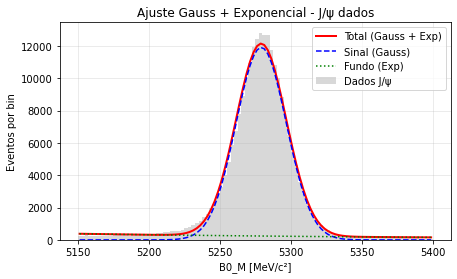

In [105]:
bins = 100
vals, edges = np.histogram(mass_jpsi, bins=bins, range=(mass_min_jpsi, mass_max_jpsi))
centers = 0.5 * (edges[:-1] + edges[1:])
width = edges[1] - edges[0]

pdf_sig = zfit.run(signal_pdf_jpsi.pdf(centers))
pdf_bkg = zfit.run(bkg_pdf_jpsi.pdf(centers))

y_sig = pdf_sig * nsig_jpsi.value() * width
y_bkg = pdf_bkg * nbkg_jpsi.value() * width
y_tot = y_sig + y_bkg

plt.figure(figsize=(7,4))
plt.bar(centers, vals, width=width, alpha=0.3, color='gray', label='Dados J/ψ')
plt.plot(centers, y_tot, 'r-', lw=2, label='Total (Gauss + Exp)')
plt.plot(centers, y_sig, 'b--', lw=1.5, label='Sinal (Gauss)')
plt.plot(centers, y_bkg, 'g:', lw=1.5, label='Fundo (Exp)')
plt.xlabel("B0_M [MeV/c²]")
plt.ylabel("Eventos por bin")
plt.title("Ajuste Gauss + Exponencial - J/ψ dados")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# BDT reweighter

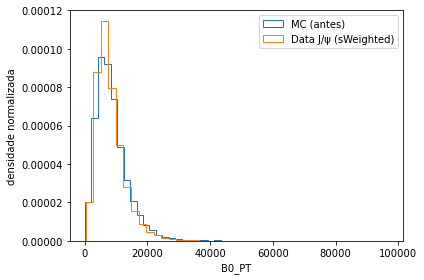

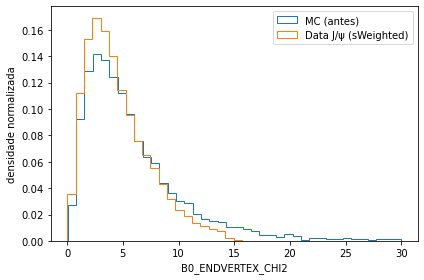

In [118]:
#import hep_ml
#from hep_ml.reweight import GBReweighter

vars_plot = [
    "B0_PT", "B0_ENDVERTEX_CHI2"
]

for var in vars_plot:
    x_data = df_jpsi_sel[var].to_numpy()
    w_data = df_jpsi_sel["w_sig_jpsi"].to_numpy()
    x_mc   = df_sig[var].to_numpy()

    plt.figure()
    plt.hist(x_mc, bins=40, density=True, histtype="step", label="MC (antes)")
    plt.hist(x_data, bins=40, density=True, weights=w_data, histtype="step", label="Data J/ψ (sWeighted)")
    plt.xlabel(var)
    plt.ylabel("densidade normalizada")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [119]:
import xgboost as xgb

X_tgt = df_jpsi_sel[vars_plot].to_numpy()            # Data (alvo)
w_tgt = df_jpsi_sel["w_sig_jpsi"].to_numpy()         # sWeights do sinal
X_ref = df_sig[vars_plot].to_numpy()                 # MC sinal (origem)
w_ref = np.ones(len(df_sig), dtype=float)            # peso inicial (=1)


# Pesos só para TREINO do classificador (evitar negativos/zeros) ===
eps = 1e-6
w_tgt_train = np.clip(w_tgt, eps, None)             # piso positivo
# diagnosticar quantos negativos existiam:
print("sWeights negativos no alvo:", np.sum(w_tgt <= 0))

X = np.vstack([X_ref, X_tgt])
y = np.concatenate([np.zeros(len(X_ref), dtype=int), np.ones(len(X_tgt), dtype=int)])
w = np.concatenate([w_ref, w_tgt_train])

clf = xgb.XGBClassifier(
    n_estimators=300, max_depth=3, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    tree_method="hist", eval_metric="logloss", n_jobs=-1, use_label_encoder=False
)
clf.fit(X, y, sample_weight=w)

# converter p(data|x) -> razão r(x) e pesos finais no MC
p_ref = clf.predict_proba(X_ref)[:, 1]
p_ref = np.clip(p_ref, eps, 1.0 - eps)
ratio  = p_ref / (1.0 - p_ref)

# normalização global: use os sWeights ORIGINAIS (com sinal) para casar totais
factor = float(np.sum(w_ref) / np.sum(w_tgt))
w_rw   = factor * ratio

df_sig = df_sig.copy()
df_sig["w_rw_xgb"] = w_rw

print("Resumo w_rw_xgb — min/mediana/max:",
      float(w_rw.min()), float(np.median(w_rw)), float(w_rw.max()))
print("Soma pesos (MC reweighted)  =", float(w_rw.sum()))
print("Soma sWeights (Data alvo)   =", float(w_tgt.sum()))




sWeights negativos no alvo: 15556


/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:13:29] WARNING: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-2.1.3/src/xgboost/2.1.3/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resumo w_rw_xgb — min/mediana/max: 0.006840915884822607 1.088104009628296 2.939870834350586
Soma pesos (MC reweighted)  = 10343.849609375
Soma sWeights (Data alvo)   = 210777.98597613795


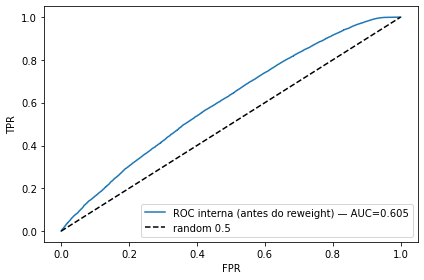

AUC interna = 0.605


In [120]:
from sklearn.metrics import roc_curve, auc

# prob(data|x) do classificador que TREINOU o reweighter
p_data = clf.predict_proba(df_jpsi_sel[vars_plot].to_numpy())[:, 1]
p_mc   = clf.predict_proba(df_sig[vars_plot].to_numpy())[:, 1]

y_true = np.concatenate([np.ones_like(p_data), np.zeros_like(p_mc)])
scores = np.concatenate([p_data, p_mc])
weights= np.concatenate([df_jpsi_sel["w_sig_jpsi"].to_numpy(), np.ones(len(p_mc))])

fpr, tpr, _ = roc_curve(y_true, scores, sample_weight=weights)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC interna (antes do reweight) — AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],"k--",label="random 0.5")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()
print(f"AUC interna = {roc_auc:.3f}")


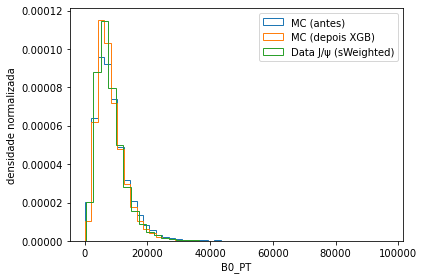

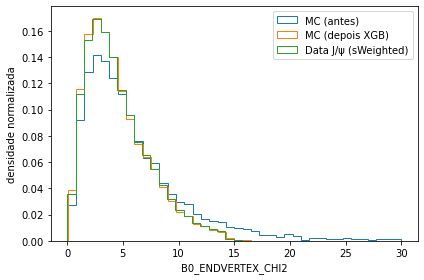

In [121]:
for var in vars_plot:
    x_data = df_jpsi_sel[var].to_numpy()
    w_data = df_jpsi_sel["w_sig_jpsi"].to_numpy()
    x_mc   = df_sig[var].to_numpy()
    w_rw   = df_sig["w_rw_xgb"].to_numpy()   # pesos do reweighter

    plt.figure()
    plt.hist(x_mc, bins=40, density=True, histtype="step", label="MC (antes)")
    plt.hist(x_mc, bins=40, density=True, weights=w_rw, histtype="step", label="MC (depois XGB)")
    plt.hist(x_data, bins=40, density=True, weights=w_data, histtype="step", label="Data J/ψ (sWeighted)")
    plt.xlabel(var)
    plt.ylabel("densidade normalizada")
    plt.legend()
    plt.tight_layout()
    plt.show()